In [2]:
import torch
from torch import optim
import numpy as np

from PIL import Image 

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from pathlib import Path

from torchvision import transforms
from torchvision import models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import lr_scheduler

import os
import pandas as pd
from time import time

from matplotlib import colors, patches, pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Data Downloading

In [3]:
! gdown https://drive.google.com/drive/folders/1X9A_4X4ZZMYIwqwo2MsTeLLv8w-orIBv?usp=sharing

/usr/local/lib/python2.7/dist-packages/gdown/parse_url.py:31: UserWarning: You specified Google Drive Link but it is not the correct link to download the file. Maybe you should try: https://drive.google.com/uc?id=None
  .format(url='https://drive.google.com/uc?id={}'.format(file_id))
Downloading...
From: https://drive.google.com/drive/folders/1X9A_4X4ZZMYIwqwo2MsTeLLv8w-orIBv?usp=sharing
To: /content/1X9A_4X4ZZMYIwqwo2MsTeLLv8w-orIBv?usp=sharing
252kB [00:00, 1.17MB/s]


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
!unzip -q /content/gdrive/MyDrive/simpsons/testset.zip -d test
!unzip -q /content/gdrive/MyDrive/simpsons/train.zip -d train

In [6]:
!ls train

__MACOSX  train


In [7]:
# differnet dataset modes
DATA_MODES = ['train', 'val', 'test']
# all images will be scaled to size 224x224 px
RESCALE_SIZE = 224
# working on gpu
DEVICE = torch.device("cuda")

In [8]:
class SimpsonsDataset(Dataset):
    
    def __init__(self, files, mode):
        super().__init__()
        # dataset for download
        self.files = sorted(files)
        # dataset mode by model mode
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index, RESCALE_SIZE=256):
        # transformation by mode and normalization
        transformers = {
            'train': 
            transforms.Compose([
                      transforms.RandomResizedCrop(size=RESCALE_SIZE),
                      transforms.RandomPerspective(distortion_scale=0.1),
                      transforms.RandomRotation(degrees=15),
                      transforms.ColorJitter(),
                      transforms.RandomHorizontalFlip(),
                      transforms.CenterCrop(size=RESCALE_SIZE),  # Imagenet standards
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])            
            ]),
            'val':
            transforms.Compose([
                      transforms.Resize(size=RESCALE_SIZE+20),
                      transforms.CenterCrop(size=RESCALE_SIZE),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])
            ]),
            'test':
            transforms.Compose([
                      transforms.Resize(size=RESCALE_SIZE+20),
                      transforms.CenterCrop(size=RESCALE_SIZE),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }

        x = self.load_sample(self.files[index])

        # mode -> transformer
        if self.mode == 'train':
            x = transformers['train'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        elif self.mode == 'val':
            x = transformers['val'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        else:
            x = transformers['test'](x)
            return x
        

# Statictic and Analisys

In [9]:
# Empty lists
traindir = '/content/gdrive/MyDrive/simpsons/train/simpsons_dataset/'
categories = []
img_categories = []
n_train = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    n_train.append(len(train_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       }).sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)

In [10]:
 cat_df.tail(10)

,category,n_train
4,rainier_wolfcastle,45
39,agnes_skinner,42
15,sideshow_mel,40
37,otto_mann,32
11,fat_tony,27
21,gil,27
38,miss_hoover,17
41,disco_stu,8
40,troy_mcclure,8
18,lionel_hutz,3


There are three classes with less than 10 samples.

In [11]:
cat_df.to_csv('/content/cat_info.csv')

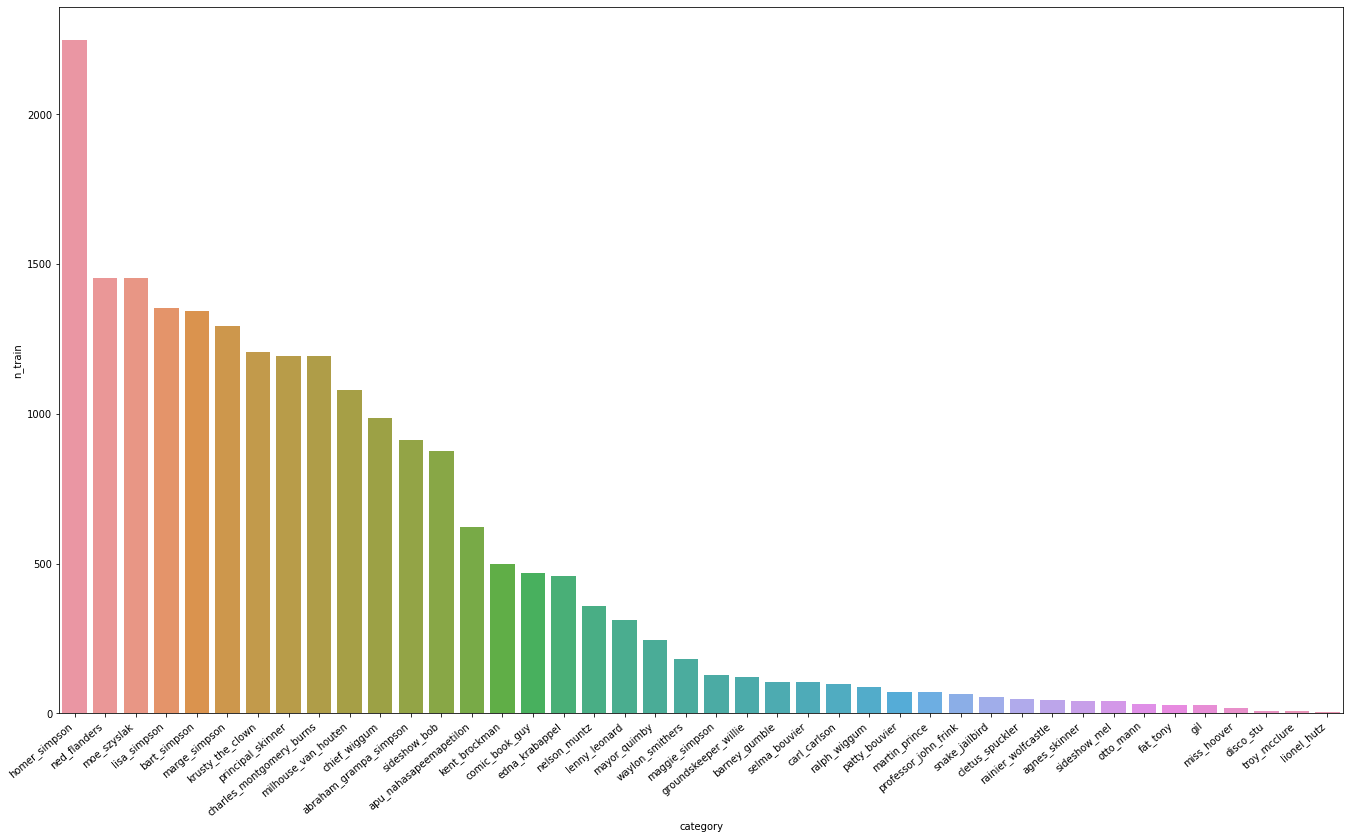

In [12]:
plt.figure(figsize=(23,13))
ax = sns.barplot(x = cat_df.category, y = cat_df.n_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, horizontalalignment='right')
None

In [13]:
print(f'image_height_min ={image_df.height.min()}', f', image_width_min ={image_df.width.min()}')
print(f'image_height_max ={image_df.height.max()}', f', image_width_max ={image_df.width.max()}')

image_height_min =256 , image_width_min =256
image_height_max =1072 , image_width_max =1912


# Create Datasets

In [14]:
TRAIN_DIR = Path('/content/gdrive/MyDrive/simpsons/train')
TEST_DIR = Path('/content/gdrive/MyDrive/simpsons/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
# differnet dataset modes
DATA_MODES = ['train', 'val', 'test']
# all images will be scaled to size 224x224 px
RESCALE_SIZE = 256
# working on gpu
DEVICE = torch.device("cuda")

**Let's split datasets on train and val**

In [18]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify = train_val_labels, random_state = 13)

In [19]:
train_files_labels = [path.parent.name for path in train_files]
val_files_labels = [path.parent.name for path in val_files]

In [30]:
print(f'Train dataset len:{len(train_files_labels)}, n_classes:{len(set(train_files_labels))}')
print(f'Val dataset len:{len(val_files_labels)}, n_classes:{len(set(val_files_labels))}')


Train dataset len:16746, n_classes:42
Val dataset len:4187, n_classes:42


In [31]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

# Functions for image visualisation
Function for visualization random image from train and val datasets

In [32]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


# grid of random images from train dataset
def imshow_grid(nrows, ncols, mode):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16, 8), \
                            sharey=True, sharex=True)
    for fig_x in ax.flatten():
        
        if mode == 'train':
          random_characters = int(np.random.uniform(0, len(train_dataset)))
          img, label = train_dataset[random_characters]
          img_label = " ".join(map(lambda x: x.capitalize(),\
                     train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
        
        elif mode == 'val':
          random_characters = int(np.random.uniform(0, len(val_dataset)))
          img, label = val_dataset[random_characters]
          img_label = " ".join(map(lambda x: x.capitalize(),\
                     val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

        imshow(img.data.cpu(), title=img_label,plt_ax=fig_x)

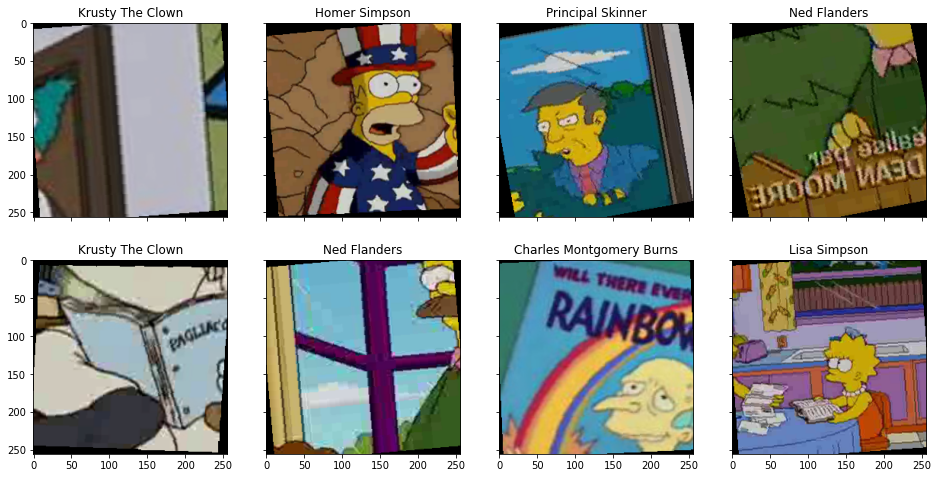

In [33]:
imshow_grid(2, 4, 'train')

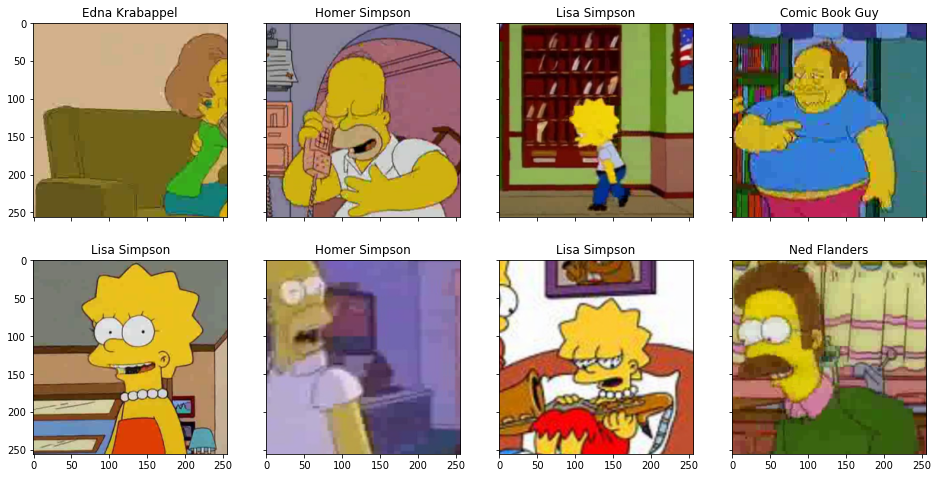

In [34]:
imshow_grid(2, 4, 'val')

# Functions for model's training
Epoch training

In [35]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    # true loss and accuracy 
    train_loss = running_loss / processed_data 
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

Epoch validation

In [36]:
def eval_epoch(model, val_loader, criterion):
    model.eval() 
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    val_loss = running_loss / processed_data 
    val_acc = running_corrects.cpu().numpy() / processed_data

    return val_loss, val_acc

# Train loop

In [69]:
import time

def train(train_dataset, val_dataset, model, epochs, batch_size, criterion, optimizer, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0


    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} \n train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc='epoch', total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)

            scheduler.step()
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)

            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss,\
                                           t_acc=train_acc, v_acc=val_acc))
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )) 
    print('Best val acc: {:4f}'.format(best_acc))

    # best model's params
    model.load_state_dict(best_model_wts)

    return model, history

In [56]:
def train(train_dataset, val_dataset, model, epochs, batch_size, shuffle=True, sampler=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 3, 0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

loop to train on validation dataset because of unbalanced classes.

probabilities prediction fucntion

In [39]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Loss visualization

In [40]:
def show_loss(history):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(12, 8))
    plt.plot(loss, label="train")
    plt.plot(val_loss, label="val")
    plt.legend()
    plt.show()

# VGG_16

In [42]:
vgg_16 = models.vgg16(pretrained=True)
vgg_16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Freeze the layers**

In [43]:
layers_to_unfreeze = 20
for param in vgg_16.features[:-layers_to_unfreeze].parameters():
  param.requaires_grad = False

In [60]:
# dense in_features
num_features = 25088

# numbers of classes to classificztion
n_classes = len(np.unique(train_val_labels))

# replace fully-connected layer by our classification linear layer
vgg_16.classifier = nn.Sequential(
                    nn.Linear(in_features=num_features, out_features=4096, bias=True),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5, inplace=False),
                    nn.Linear(in_features=4096, out_features=4096, bias=True),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5, inplace=False),
                    nn.Linear(in_features=4096, out_features=n_classes)
)

vgg_16.to(DEVICE)

# cost function
criterion_vgg = nn.CrossEntropyLoss()

# AdamW as optimizer
optimizer_vgg = optim.AdamW(list(vgg_16.features.parameters())[-layers_to_unfreeze:] + 
                            list(vgg_16.classifier.parameters()), lr=3e-4)

# scheduler init
scheduler_vgg = lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)

In [70]:
%%time
vgg_16, history = train(train_dataset, val_dataset, vgg_16, epochs=20, batch_size=64, 
                        criterion=criterion_vgg,
                        optimizer=optimizer_vgg,
                        scheduler=scheduler_vgg)

epoch:   5%|▌         | 1/20 [06:36<2:05:41, 396.92s/it]


Epoch 001 train_loss: 0.5516     val_loss 0.2143 
 train_acc 0.8557 val_acc 0.9537


epoch:  10%|█         | 2/20 [13:11<1:58:37, 395.43s/it]


Epoch 002 train_loss: 0.5440     val_loss 0.2141 
 train_acc 0.8542 val_acc 0.9539


epoch:  15%|█▌        | 3/20 [19:47<1:52:06, 395.66s/it]


Epoch 003 train_loss: 0.5509     val_loss 0.2140 
 train_acc 0.8539 val_acc 0.9539


epoch:  20%|██        | 4/20 [26:19<1:45:11, 394.45s/it]


Epoch 004 train_loss: 0.5394     val_loss 0.2140 
 train_acc 0.8542 val_acc 0.9539


epoch:  25%|██▌       | 5/20 [32:49<1:38:13, 392.87s/it]


Epoch 005 train_loss: 0.5593     val_loss 0.2140 
 train_acc 0.8525 val_acc 0.9539


epoch:  30%|███       | 6/20 [39:21<1:31:31, 392.28s/it]


Epoch 006 train_loss: 0.5471     val_loss 0.2138 
 train_acc 0.8542 val_acc 0.9539


epoch:  35%|███▌      | 7/20 [45:54<1:25:05, 392.70s/it]


Epoch 007 train_loss: 0.5631     val_loss 0.2138 
 train_acc 0.8487 val_acc 0.9539


epoch:  40%|████      | 8/20 [52:29<1:18:39, 393.31s/it]


Epoch 008 train_loss: 0.5754     val_loss 0.2138 
 train_acc 0.8469 val_acc 0.9539


epoch:  45%|████▌     | 9/20 [59:03<1:12:11, 393.75s/it]


Epoch 009 train_loss: 0.5558     val_loss 0.2138 
 train_acc 0.8526 val_acc 0.9539


epoch:  50%|█████     | 10/20 [1:05:30<1:05:13, 391.39s/it]


Epoch 010 train_loss: 0.5577     val_loss 0.2138 
 train_acc 0.8510 val_acc 0.9539


epoch:  55%|█████▌    | 11/20 [1:11:57<58:32, 390.23s/it]


Epoch 011 train_loss: 0.5576     val_loss 0.2138 
 train_acc 0.8503 val_acc 0.9539


epoch:  60%|██████    | 12/20 [1:18:25<51:55, 389.45s/it]


Epoch 012 train_loss: 0.5623     val_loss 0.2139 
 train_acc 0.8506 val_acc 0.9539


epoch:  65%|██████▌   | 13/20 [1:24:55<45:26, 389.54s/it]


Epoch 013 train_loss: 0.5601     val_loss 0.2138 
 train_acc 0.8501 val_acc 0.9539


epoch:  70%|███████   | 14/20 [1:31:29<39:06, 391.01s/it]


Epoch 014 train_loss: 0.5580     val_loss 0.2138 
 train_acc 0.8499 val_acc 0.9539


epoch:  75%|███████▌  | 15/20 [1:38:02<32:38, 391.70s/it]


Epoch 015 train_loss: 0.5688     val_loss 0.2138 
 train_acc 0.8518 val_acc 0.9539


epoch:  80%|████████  | 16/20 [1:44:33<26:05, 391.50s/it]


Epoch 016 train_loss: 0.5481     val_loss 0.2138 
 train_acc 0.8554 val_acc 0.9539


epoch:  85%|████████▌ | 17/20 [1:51:05<19:34, 391.59s/it]


Epoch 017 train_loss: 0.5469     val_loss 0.2138 
 train_acc 0.8527 val_acc 0.9539


epoch:  90%|█████████ | 18/20 [1:57:32<13:00, 390.25s/it]


Epoch 018 train_loss: 0.5722     val_loss 0.2138 
 train_acc 0.8505 val_acc 0.9539


epoch:  95%|█████████▌| 19/20 [2:03:59<06:29, 389.30s/it]


Epoch 019 train_loss: 0.5719     val_loss 0.2138 
 train_acc 0.8490 val_acc 0.9539


epoch: 100%|██████████| 20/20 [2:10:26<00:00, 391.33s/it]


Epoch 020 train_loss: 0.5504     val_loss 0.2138 
 train_acc 0.8541 val_acc 0.9539
Training complete in 130m 27s
Best val acc: 0.953905
CPU times: user 2h 10s, sys: 2min 54s, total: 2h 3min 4s
Wall time: 2h 10min 26s


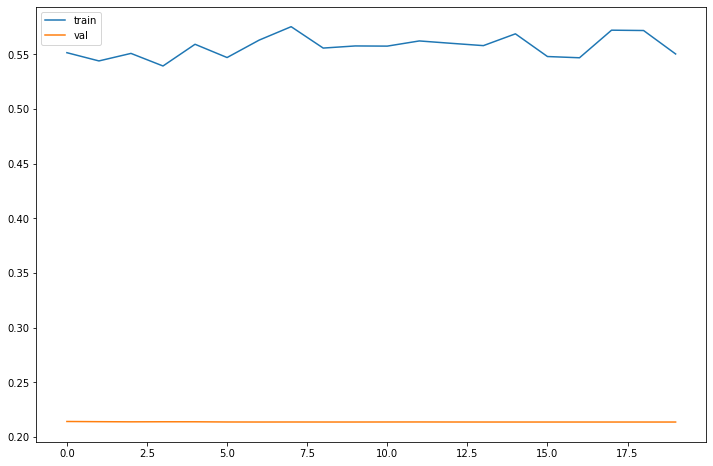

In [71]:
 show_loss(history)

Saving model

In [72]:
torch.save(vgg_16.state_dict(), 'vgg_16.pth') 

# MobileNetV3_small


In [73]:
mobNet = models.mobilenet_v3_small(pretrained=True)
mobNet

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

In [74]:
num_features = 576
n_classes = len(np.unique(train_files_labels))
mobNet.classifier = nn.Sequential(
                    nn.Linear(num_features, 1024, bias=True),
                    nn.Hardswish(),
                    nn.Dropout(p=0.2, inplace=True),
                    nn.Linear(1024, n_classes, bias=True)
)

mobNet.to(DEVICE)

criterion_mobNet = nn.CrossEntropyLoss()

optimizer_mobNet = optim.AdamW(mobNet.parameters(), lr=3e-4)

scheduler_mobNet = lr_scheduler.StepLR(optimizer_mobNet, step_size=7, gamma=0.1)

In [75]:
mobNet, history = train(train_dataset, val_dataset, mobNet, epochs=10, batch_size=64,
                        criterion = criterion_mobNet,
                        optimizer = optimizer_mobNet,
                        scheduler = scheduler_mobNet
                        )

epoch:  10%|█         | 1/10 [03:38<32:50, 218.95s/it]


Epoch 001 train_loss: 1.6747     val_loss 0.6199 
 train_acc 0.5619 val_acc 0.8319


epoch:  20%|██        | 2/10 [07:23<29:36, 222.09s/it]


Epoch 002 train_loss: 0.8729     val_loss 0.3390 
 train_acc 0.7681 val_acc 0.9104


epoch:  30%|███       | 3/10 [11:07<26:00, 222.89s/it]


Epoch 003 train_loss: 0.6985     val_loss 0.2568 
 train_acc 0.8139 val_acc 0.9410


epoch:  40%|████      | 4/10 [14:47<22:11, 221.99s/it]


Epoch 004 train_loss: 0.6225     val_loss 0.2430 
 train_acc 0.8330 val_acc 0.9372


epoch:  50%|█████     | 5/10 [18:28<18:27, 221.44s/it]


Epoch 005 train_loss: 0.5594     val_loss 0.2021 
 train_acc 0.8504 val_acc 0.9518


epoch:  60%|██████    | 6/10 [22:09<14:45, 221.47s/it]


Epoch 006 train_loss: 0.5171     val_loss 0.1842 
 train_acc 0.8625 val_acc 0.9568


epoch:  70%|███████   | 7/10 [25:51<11:04, 221.59s/it]


Epoch 007 train_loss: 0.5237     val_loss 0.1891 
 train_acc 0.8595 val_acc 0.9551


epoch:  80%|████████  | 8/10 [29:33<07:23, 221.84s/it]


Epoch 008 train_loss: 0.4349     val_loss 0.1590 
 train_acc 0.8853 val_acc 0.9642


epoch:  90%|█████████ | 9/10 [33:16<03:42, 222.14s/it]


Epoch 009 train_loss: 0.3983     val_loss 0.1581 
 train_acc 0.8905 val_acc 0.9639


epoch: 100%|██████████| 10/10 [36:55<00:00, 221.51s/it]


Epoch 010 train_loss: 0.4032     val_loss 0.1516 
 train_acc 0.8918 val_acc 0.9658
Training complete in 36m 55s
Best val acc: 0.965847


In [76]:
mobNet, history = val_training(val_dataset, mobNet, epochs=5, batch_size=64,
                               criterion = criterion_mobNet,
                               optimizer = optimizer_mobNet,
                               scheduler = scheduler_mobNet
                               )

epoch:  20%|██        | 1/5 [00:38<02:33, 38.27s/it]


Epoch 001 train_loss: 0.1452 train_acc 0.9675


epoch:  40%|████      | 2/5 [01:17<01:55, 38.58s/it]


Epoch 002 train_loss: 0.1136 train_acc 0.9756


epoch:  60%|██████    | 3/5 [01:55<01:17, 38.59s/it]


Epoch 003 train_loss: 0.0946 train_acc 0.9816


epoch:  80%|████████  | 4/5 [02:34<00:38, 38.64s/it]


Epoch 004 train_loss: 0.0803 train_acc 0.9845


epoch: 100%|██████████| 5/5 [03:12<00:00, 38.57s/it]


Epoch 005 train_loss: 0.0674 train_acc 0.9883
Training complete in 3m 13s
Best val acc: 0.988297


Saving model

In [77]:
 torch.save(mobNet.state_dict(), 'mobNetv3small.pth')

# MobNet v3 large

In [78]:
mobNetlarge = models.mobilenet_v3_large(pretrained=True)
mobNetlarge

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [80]:
num_features = 960
n_classes = len(np.unique(train_files_labels))
mobNetlarge.classifier = nn.Sequential(
                                  nn.Linear(num_features, 1280, bias=True),
                                  nn.Hardswish(),
                                  nn.Dropout(p=0.2, inplace=True),
                                  nn.Linear(1280, n_classes, bias=True)
)

mobNetlarge.to(DEVICE)

criterion_mobNetlarge = nn.CrossEntropyLoss()

optimizer_mobNetlarge = optim.AdamW(mobNetlarge.parameters(), lr=3e-4)

scheduler_mobNetlarge = lr_scheduler.StepLR(optimizer_mobNetlarge, step_size=7, gamma=0.1)

In [81]:
mobNetlarge, hisory = train(train_dataset, val_dataset, mobNetlarge, epochs=15, batch_size=64,
                            criterion = criterion_mobNetlarge,
                            optimizer = optimizer_mobNetlarge,
                            scheduler = scheduler_mobNetlarge
                            )

epoch:   7%|▋         | 1/15 [04:05<57:20, 245.76s/it]


Epoch 001 train_loss: 1.3590     val_loss 0.3344 
 train_acc 0.6510 val_acc 0.9100


epoch:  13%|█▎        | 2/15 [08:11<53:14, 245.75s/it]


Epoch 002 train_loss: 0.7134     val_loss 0.2544 
 train_acc 0.8117 val_acc 0.9374


epoch:  20%|██        | 3/15 [12:23<49:42, 248.56s/it]


Epoch 003 train_loss: 0.5524     val_loss 0.1890 
 train_acc 0.8564 val_acc 0.9565


epoch:  27%|██▋       | 4/15 [16:35<45:49, 249.98s/it]


Epoch 004 train_loss: 0.5049     val_loss 0.1716 
 train_acc 0.8649 val_acc 0.9592


epoch:  33%|███▎      | 5/15 [20:49<41:52, 251.28s/it]


Epoch 005 train_loss: 0.4568     val_loss 0.1615 
 train_acc 0.8794 val_acc 0.9632


epoch:  40%|████      | 6/15 [25:02<37:48, 252.04s/it]


Epoch 006 train_loss: 0.4314     val_loss 0.1251 
 train_acc 0.8836 val_acc 0.9728


epoch:  47%|████▋     | 7/15 [29:08<33:20, 250.03s/it]


Epoch 007 train_loss: 0.4107     val_loss 0.1322 
 train_acc 0.8905 val_acc 0.9694


epoch:  53%|█████▎    | 8/15 [33:13<28:58, 248.34s/it]


Epoch 008 train_loss: 0.3474     val_loss 0.1005 
 train_acc 0.9058 val_acc 0.9795


epoch:  60%|██████    | 9/15 [37:17<24:41, 246.97s/it]


Epoch 009 train_loss: 0.3132     val_loss 0.0961 
 train_acc 0.9149 val_acc 0.9807


epoch:  67%|██████▋   | 10/15 [41:21<20:31, 246.25s/it]


Epoch 010 train_loss: 0.3054     val_loss 0.0960 
 train_acc 0.9186 val_acc 0.9811


epoch:  73%|███████▎  | 11/15 [45:24<16:20, 245.18s/it]


Epoch 011 train_loss: 0.2881     val_loss 0.0935 
 train_acc 0.9204 val_acc 0.9818


epoch:  80%|████████  | 12/15 [49:27<12:13, 244.48s/it]


Epoch 012 train_loss: 0.2796     val_loss 0.0984 
 train_acc 0.9255 val_acc 0.9802


epoch:  87%|████████▋ | 13/15 [53:26<08:05, 242.87s/it]


Epoch 013 train_loss: 0.2776     val_loss 0.0914 
 train_acc 0.9257 val_acc 0.9826


epoch:  93%|█████████▎| 14/15 [57:25<04:01, 241.78s/it]


Epoch 014 train_loss: 0.2811     val_loss 0.0912 
 train_acc 0.9228 val_acc 0.9840


epoch: 100%|██████████| 15/15 [1:01:28<00:00, 245.90s/it]


Epoch 015 train_loss: 0.2670     val_loss 0.0896 
 train_acc 0.9283 val_acc 0.9835
Training complete in 61m 28s
Best val acc: 0.983998


In [86]:
torch.save(mobNetlarge.state_dict(), 'mobNetlarge.pth')

# Visualization for predictions


In [87]:
def predict_one_sample(model, inputs, device=DEVICE):
  # function to predict one image
with torch.no_grad():
    inputs = inputs.to(device)
    model.eval()
    logit = model(inputs).cpu()
    probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

f1 score for random sample of validation data

In [88]:
from sklearn.metrics import f1_score
def f1_val_score(num_samples, model):
    idxs = list(map(int, np.random.uniform(0, len(val_dataset), num_samples)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)

    y_pred = np.argmax(probs_ims,-1)
    actual_labels = [val_dataset[id][1] for id in idxs]

    return f1_score(actual_labels, y_pred, average='micro')

predictions visualization

In [89]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [90]:
def preds_visual(nrows, ncols, model, label_encoder):

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16, 8), \
                            sharey=True, sharex=True)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, len(val_dataset)))
        im_val, label = val_dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



        imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

        actual_text = "Actual : {}".format(img_label)

        fig_x.add_patch(patches.Rectangle((0, 231),256,35,color='white'))
        font0 = FontProperties()
        font = font0.copy()
        font.set_family("sans-serif")
        prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
        predicted_proba = np.max(prob_pred)*100
        y_pred = np.argmax(prob_pred)

        predicted_label = label_encoder.classes_[y_pred]
        predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
        predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

        fig_x.text(1, 231, predicted_text , horizontalalignment='left', fontproperties=font,
                        verticalalignment='top',fontsize=9, color='black',fontweight='bold')

# Simple CNN

In [91]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(96 * 5 * 5, 96),
            nn.Linear(96, n_classes)
        )
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

# Kaggle Submit

In [93]:
# we need our label encoder 
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

dataFrame of predictions

In [94]:
def submit_df(model, label_encoder, batch_size):
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
  
    probs = predict(model, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    test_filenames = [path.name for path in test_dataset.files]

    my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

    return my_submit


creating files with predictions

In [95]:
def save_pred(model, name):
  my_submit_mbnet_01 = submit_df(model, label_encoder, 64)
  my_submit_mbnet_01.to_csv('/content/{}.csv'.format(name), index=False)

# Submitting
vgg_16

In [96]:
vgg_16.load_state_dict(torch.load('/content/vgg_16.pth'))

<All keys matched successfully>

In [98]:
print(f'f1_score vgg: {f1_val_score(1000, vgg_16)}')

f1_score vgg: 0.96


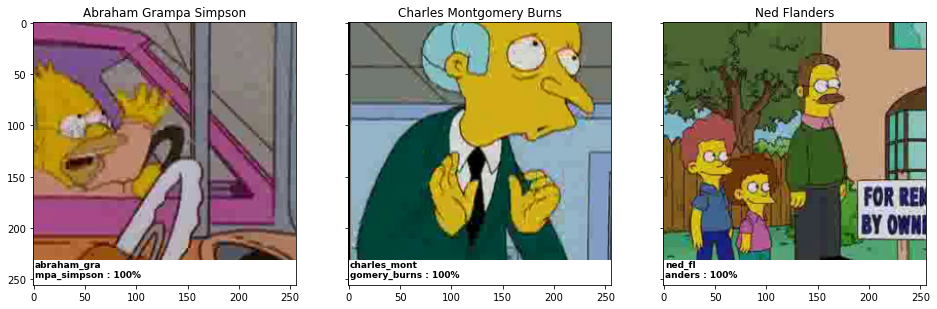

In [99]:
preds_visual(1, 3, vgg_16, label_encoder)

In [101]:
save_pred(vgg_16, 'submit_vgg16')

mobileNet_v3_small

In [102]:
mobNet.load_state_dict(torch.load('/content/mobNetv3small.pth'))

<All keys matched successfully>

In [104]:
print(f'f1_score mobileNet_v3_small: {f1_val_score(1000, mobNet)}')

f1_score mobileNet_v3_small: 0.985


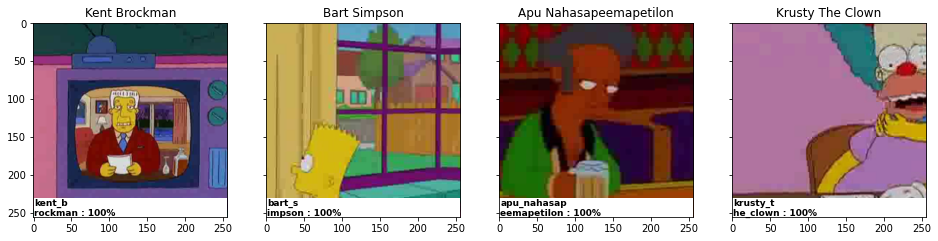

In [105]:
preds_visual(1, 4, mobNet, label_encoder)

In [106]:
save_pred(mobNet, 'submit_mobnet')

mobileNet_v3_large

In [108]:
mobNetlarge.load_state_dict(torch.load('/content/mobNetlarge.pth'))

<All keys matched successfully>

In [111]:
print(f'f1_score mobileNet_v3_large: {f1_val_score(1000, mobNetlarge)}')

f1_score mobileNet_v3_large: 0.977


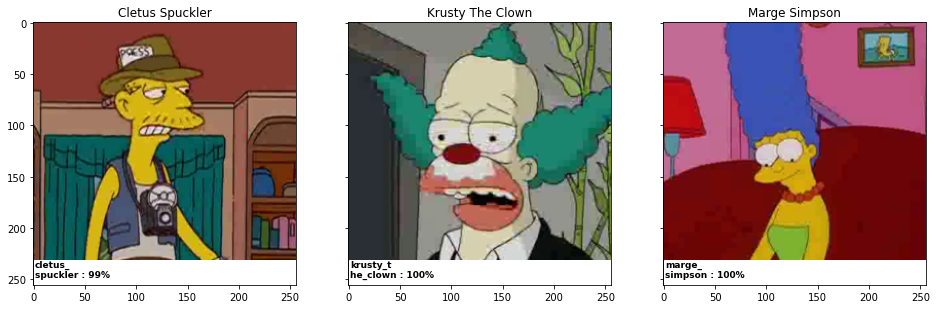

In [112]:
preds_visual(1, 3, mobNetlarge,label_encoder)

In [113]:
save_pred(mobNetlarge, 'submit_mobnetlarge')

kaggle leaderboard = 0.99681